<img src=https://raw.githubusercontent.com/superwise-ai/quickstart/f395a719ac93377005c6ce8bacebc425bf667cf1/docs/images/white_mode_logo.svg 
width="400" alt="Superwise">


# 🎉 **<font color='008aec'>Getting Started</font>**



This guide will walk you through the creation and configuration of a new model on the platform - giving you model observability in 5 minutes!


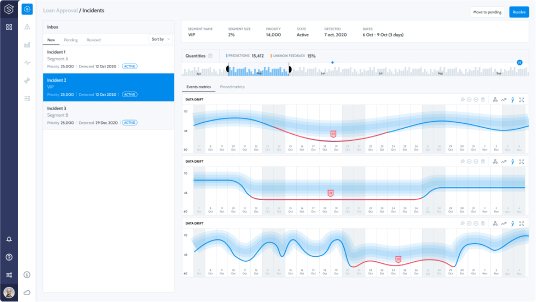


[1. Import Superwise package](#import_superwise_package)

[2. Simulate model training flow](#simulate_model_training_flow)

[3. Let's integrate with Superwise](#lets_integrate_with_superwise)
- [3.1 Create a Project](#create_a_project)
- [3.2 Create a Model](#create_a_model)
- [3.3 Create a Version](#create_a_version)
- [3.4 Create a Policy](#create_policy)
  - [3.4.1 Configure notification channel](#create_notification)
  - [3.4.2 Create Policy](#config_policy)
- [3.5 Log production data](#log_production_data)

#### ***Prerequisite packages***

In [ ]:
!pip install superwise  > /dev/null 2>&1 && echo "Superwise installation finished sucessfully"

### Restart the kernel

Once you've installed everything, you need to restart the notebook kernel so it can find the packages.

# 📦️ <font color='008aec'><a name="import_superwise_package">**Import Superwise package**</a></font>

In [ ]:
import os

# Automatically restart kernel after installs
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

The Superwise SDK is a standard Python package that simplifies the integration with Superwise and streams data to the Superwise platform.

For demostration purpose we will use:
* pandas for loading our diamonds data & working with dataframes
* numpy for dataframe operations
* sklearn for default ML operations such as train-test split, encoders, model trainning etc

Clarifications:
* Superwise.models.project.Project - represents an isolated project space that holds models
* Superwise.models.model.Model - represents an ML model in production
* Superwise.models.version.Version - represents a particular model form, with baseline data and features
* DataEntityRole - describes the dtype and role of the feature

In [ ]:
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from superwise import Superwise
from superwise.models.project import Project
from superwise.models.model import Model
from superwise.models.version import Version
from superwise.models.dataset import Dataset
from superwise.resources.superwise_enums import NotifyUpon, ScheduleCron

<a name="initiate_superwise_client"></a>
## <font color='008aec'>**Initiate Superwise client**</font>

There are 2 environment variables used to identify and authenticate your connection:
* SUPERWISE_CLIENT_ID
* SUPERWISE_SECRET

Read [here](https://docs.superwise.ai/docs/authentication) to understand how to
 generate them.


In [ ]:
os.environ['SUPERWISE_CLIENT_ID'] = '[REPLACE_WITH_YOUR_CLIENT]'
os.environ['SUPERWISE_SECRET'] = '[REPLACE_WITH_YOUR_SECRET]'

To interact with the Superwise APIs, create an instance of the Superwise object. All APIs will now be accessible under the sw instance.


In [ ]:
sw = Superwise()

<a name="simulate_model_training_flow"></a>
# 🤡 <font color='008aec'>**Simulate model training flow**</font>

For this tutorial, we use the Diamonds public dataset. This classic dataset contains the prices and other attributes of almost 54,000 diamonds.


#### Load data

In [ ]:
diamonds = pd.read_csv('https://www.openml.org/data/get_csv/21792853/dataset')
diamonds.head()

Dataset properties:
- carat weight of the diamond (0.2--5.01)
- cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color diamond color, from J (worst) to D (best)
- clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table width of top of diamond relative to widest point (43--95)
- price price in US dollars ($326--$18,823) - Label
- x length in mm (0--10.74)
- y width in mm (0--58.9)
- z depth in mm (0--31.8)


#### Split Train-Test

We’ll split the dataset into training and test sets. The training dataset will be used later as a reference dataset for the baseline. The test dataset will simulate production data that feeds into the model. You can read more about the baseline dataset concept [here](https://docs.superwise.ai/docs/baseline)


In [ ]:
X = diamonds.drop(columns="price")
y = diamonds["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head()

#### Pre-processing

To use categorical features in our model, we will first transform them into numerical values using one-hot encoding

In [ ]:
categorical_cols = ['cut', 'clarity', 'color']

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical',  OneHotEncoder(), categorical_cols)
    ], remainder='passthrough')

#### Train your model

In this example, we train a simple Liner Regression

In [ ]:
diamond_price_model=LinearRegression()

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', diamond_price_model)
])

my_pipeline.fit(X_train, y_train)

#### Predict

We can now use the model we trained to predict the price


In [ ]:
y_pred_train =  my_pipeline.predict(X_train)

<a name="lets_integrate_with_superwise"></a>
# 🧑‍💻 <font color='008aec'>**Let's integrate with Superwise**</font>

Now that we have a trained model, we can begin by logging it into the Superwise platform and starting to monitor its behavior.


<a name="create_a_project"></a>
#### Create a Project

A *Project* represents an isolated working environment.

A project can hold many models, but a model can only (and must) have 1 project.

In [ ]:
project = Project(
    name="My First Project",
    description="project for my first model"
)

project = sw.project.create(project)
print(f"New project Created - {project.id}")

<a name="create_a_model"></a>
#### Create a Model

Models, or machine learning-based decision processes are the basic atomic component that Superwise observes

In [ ]:
diamond_model = Model(
    name="Diamond Model",
    description="Regression model that predicts the diamond price",
    project_id=project.id
)

diamond_model = sw.model.create(diamond_model)
print(f"New model Created - {diamond_model.id}")

A new model will appear in [superwise.ai](https://portal.superwise.ai)

<img src="images/new_model.png">

<a name="create_a_version"></a>
#### Create a Version

Deploying a model to production is only the first step, since models require continuous improvement and ongoing updates. The differences between versions may be ad hoc schema changes or retraining on a new data set to refit the model hyperparameters under the same given schema.

The process contains 3 main steps 
    - Prepare the baseline dataset based on the training data
    - Define the version schema
    - Log the version into the Superwise app

#### Prepare Reference Dataset

We’re now going to add 4 columns to our dataset
* ID - Unique identifier per row or prediction (Required)
* Timestamp - Indicates when the prediction took place (Required)
* Model prediction
* Label - The real diamond price

In [ ]:
training_data = X_train.assign(
    id=X_train.index,
    ts=pd.Timestamp.now(),
    prediction=y_pred_train,
    price=y_train
)
training_data["prediction"] = training_data["prediction"].astype(float)

data_dir = 'data'
training_data_filename = 'training.csv'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
training_data_filepath = os.path.join(data_dir, training_data_filename)  

training_data.to_csv(training_data_filepath, index=False)
training_data.head()

#### Create Dataset Object

The dataset will be processed by Superwise during creation, and will hold, among other metadata, the roles and data types of the columns of the actual data. The columns are represented as Data Entities in Superwise.

For reference: https://docs.superwise.ai/docs/version

In [ ]:
from superwise.resources.superwise_enums import DataEntityRole

dataset = Dataset(name="💎 Training Dataset",
                  files=[training_data_filepath],
                  project_id=project_id,
                  roles={
                    DataEntityRole.PREDICTION_VALUE.value:"prediction",
                    DataEntityRole.TIMESTAMP.value:"ts",
                    DataEntityRole.LABEL.value:["price"],
                    DataEntityRole.ID.value:"id"})
# Create the dataset in Superwise, may take some time to process
dataset = sw.dataset.create(dataset)

In [ ]:
import json
print(json.dumps(dataset.roles, indent=2))

#### Activate a version

Now that we have a model and schema, let’s combine them together into a version.


In [ ]:
new_version = Version(
    model_id=diamond_model.id,
    name="1.0.0",
    dataset_id=dataset.id
)

new_version = sw.version.create(new_version)

In [ ]:
sw.version.activate(new_version.id)

We should now see activated version in Diamond Model Versions page

<img src="images/new_version.png">

<a name="create_policy"></a>
## 📄 <font color='008aec'>**Create Policy**</font>
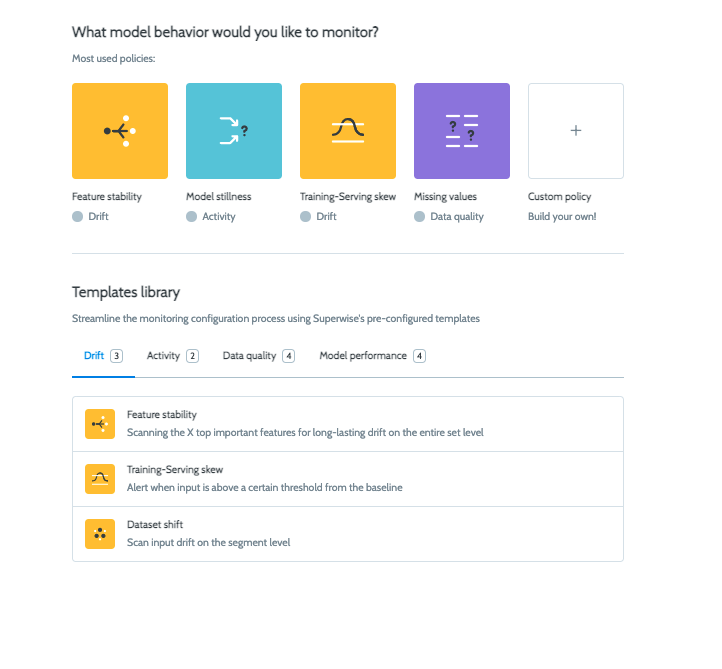

Before we starting send data to the system, let's configure a policy to notify us on anomalies detected by Superwise platform.

we will list all th policy templates available and choose 
a template to create the policy from.

In [ ]:
templates = sw.policy.get_policy_templates()
templates

In [ ]:
template_name = 'Feature stability'
response = sw.policy.create_policy_from_template(policy_name='my policy',model_id=diamond_model.id, template_name=template_name, notify_upon=NotifyUpon.detection, schedule=ScheduleCron.EVERY_DAY_AT_6AM,notification_channels=[])
response.json()

<a name="log_production_data"></a>
## 🔊 <font color='008aec'>**Log production data**</font>

We’ll now use the test data to simulate production data.


#### Predictions

The prediction data should include all the data entities with the following roles - Id, Timestamp, Metadata, Feature, Prediction probability, Prediction value, Label weight -- as defined in the version schema above. In our diamonds example, we’ll add the following columns: Id, Timestamp, and Model prediction.
If some data entities are missing, you’ll get a schema skew error, which means that the data will not be streaming into Superwise.

In [ ]:
y_test_pred= my_pipeline.predict(X_test)

In [ ]:
prediction_time_vector = pd.Timestamp.now().floor('h') - \
    pd.TimedeltaIndex(X_test.reset_index(drop=True).index // int(X_test.shape[0] // 30), unit='D')

ongoing_predictions = X_test.assign(
    id=X_test.index,
    ts=prediction_time_vector,
    prediction=y_test_pred
)
ongoing_predictions["prediction"] = ongoing_predictions["prediction"].astype(float)
ongoing_predictions.to_csv('data/ongoing_predictions.csv', index=False)
ongoing_predictions.head()

After we fit the data according to the schema, it’s ready to be sent to the Superwise platform. You’ll need to provide the model and the version of the model being used for the prediction.

Notice that each chunk of data should not be more than 1000 records.


In [ ]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

🚧 
While the next snippet is running, open [transactions](https://portal.superwise.ai) page within Superwise portal to see the data being loaded.


In [ ]:
ongoing_predictions_chunks = chunks(ongoing_predictions.to_dict(orient='records'), 1000)

transaction_ids = list()
for ongoing_predictions_chunk in ongoing_predictions_chunks:
    transaction_id = sw.transaction.log_records(
        model_id=diamond_model.id, 
        version_id=new_version.id, 
        records=ongoing_predictions_chunk
    )
    transaction_ids.append(transaction_id)
    print(transaction_id)

We should now see the transactions table filled with data
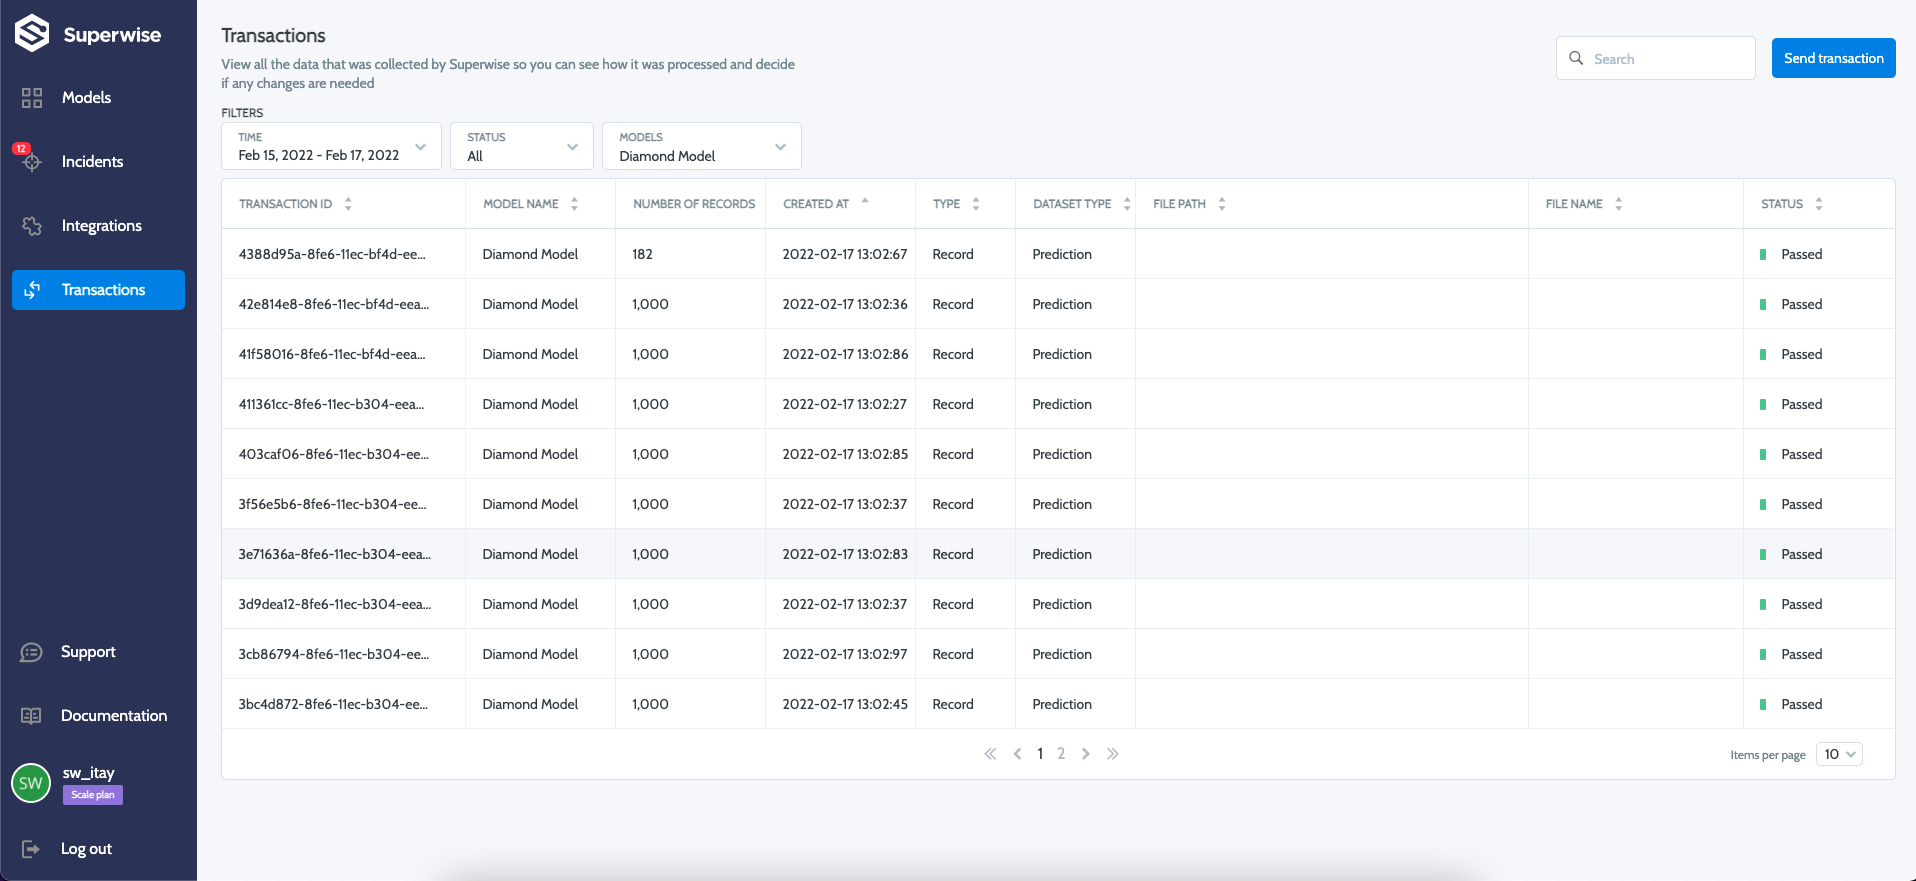

In [ ]:
transaction_id = sw.transaction.get(transaction_id=transaction_ids[0]['transaction_id'])
transaction_id.get_properties()['status']

#### Ground truth

In most ML scenarios, the ground truth comes back with a delay. To log it correctly, the data should include all the data entities with the following roles: Id, Label (as we defined in the schema). Superwise will automatically add them to the predictions that were sent earlier and use them to calculate the model performance metrics.

In [ ]:
ongoing_labels = y_test.reset_index().copy().rename(columns={"index": "id"})
ongoing_labels.to_csv('data/ongoing_labels.csv', index=False)
ongoing_labels.head()

You’ll notice that when you log the ground truth, the version_id is optional. For example, if you use 2 different versions to predict the same data record, the ground truth is relevant for both of them.

In [ ]:
ongoing_labels_chunks = chunks(ongoing_labels.to_dict(orient='records'), 1000)

transaction_ids = list()
for ongoing_labels_chunk in ongoing_labels_chunks:
    transaction_id = sw.transaction.log_records(
        model_id=diamond_model.id, 
        version_id=new_version.id, 
        records=ongoing_labels_chunk
    )
    transaction_ids.append(transaction_id)
    print(transaction_id)

In [ ]:
transaction_id = sw.transaction.get(transaction_id=transaction_ids[0]['transaction_id'])
transaction_id.get_properties()['status']